**PAQUETERIAS NECESARIAS**

In [67]:
np.fix(1.9)

1.0

In [37]:
## INCLUYE TODOS LOS PAQUETES A USAR
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import random
from tensorflow import keras
 # Bibliotecas de ayuda
import pylab as pl # SE TARDA 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import gaussian
 # Biblioteca para datos de entrenamiento
from sklearn.model_selection import train_test_split
import h5py as h # manipular extensiones
# FUNCIONES DEFINIDAS PARA USO NECESARIO
import timeit
# MODIFICACION DE TAMA;OS
import mpld3
mpld3.enable_notebook()
from IPython.display import clear_output #
import statistics as stats # usar media o desviacion estandar
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**ENTRADA DE LA INFORMACION, ORDENAMIENTO DE LA INFORMACION A USAR**

In [2]:
 # ENTRAR LA INFORMACION DESDE UN ARCHIVO EXTERNO
FILE  = h.File("DATOS/TODOS.h5", 'r')
INPUT = np.vstack([FILE["qcd/images"][:], FILE["wprime/images"][:]]); INPUT=INPUT/np.max(INPUT) # SE NORMALIZA
LABEL = np.hstack([FILE["qcd/labels"][:], FILE["wprime/labels"][:]])
OUTPUT_LINEAL = np.ones((len(LABEL), 2));
OUTPUT_LINEAL[:,0] = LABEL < 1    ;     OUTPUT_LINEAL[:,1] = LABEL > 0
 # REACONDICIONAR LA INFORMACION INPUT EN UNA MATRIX PARA SU RAPIDO ACCESO
INPUT_LINEAL = np.reshape(INPUT, [len(INPUT),-1]) # LA INFORMACION SE LINEALIZA Y SE LOCALIZA EN LAS FILAS
 # SEPARAR LA INFO PARA ENTRENAR DE LA QUE SERA USADA PARA EL TEST DE CORRESPONDENCIA
INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL, OUTPUT_LINEAL_TEST = train_test_split( 
    INPUT_LINEAL, OUTPUT_LINEAL, test_size=0.2, shuffle = True);

In [68]:
print(INPUT_LINEAL.shape)

(10497, 625)


**FUNCIONES INICIALES Y NECESARIAS PARA EL ENTRENAMIENTO**

In [3]:
## CLASE DE LOS VALORES A TENER EN CUENTA
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.placeholder("float", [None])
config.v_input= len(INPUT_LINEAL[0,:]); config.v_output = len(OUTPUT_LINEAL[0,:]);#, exp = 1 , cross_entropy = 1, n_iterations = 3000, dropout = 0.5):
config.n_capas  = 2;                    config.exp      = 1;
#self.matrix_neuronas = {} # SE RELLENARA EN EL FUTURO
config.learning_rate = 1e-1; config.cross_entropy = 1;    config.n_iterations  = 3000;
config.dropout       = 0.5;
config.n_step_visual_process = 10;
config.acc_corte = .8;
config.n_iterations_resul_mean = 10 ; # NUMERO DE VECES EN QUE SE REALIZARA LA MISMA OPERACION PARA OBTENER VALORES MEDIOS
## NO DEBEN VOLVERSE A DEFINIR BAJO NINGUN CONCEPTO
config.X = tf.compat.v1.placeholder("float", shape = [None,len(INPUT_LINEAL[0,:])] ) #, name= "input_size2"); # Estructura de la entrada
config.Y = tf.compat.v1.placeholder("float", shape = [None,len(OUTPUT_LINEAL[0,:])] ) #, name= "output_size2") #Estructura de la salida
    

In [4]:
## DEFINICION DE LOS MODOS DE ELECCION DE CAPAS OCULTAS Y NUMEROS DE NEURONAS
def neuronas( config ): #v_input, v_output, n_capas = 2, exp = 1,  modo = 'poly' ):
    #config = Dd()
    x = np.ones(config.n_capas + 2)
    #print(x)
    if  config.exp >= 1: #modo == 'poly':
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/(config.n_capas + 1 ), config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    elif config.exp < 1:
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/( config.n_capas + 1 ), -1/config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    config.matrix_neuronas = np.int64(x)
    return config

In [5]:
## ORGANIZACION DE LA ESTRUCTURA INTERNA DE ENTRENAMIENTO ##
def estructura( INPUT_LINEAL, OUTPUT_LINEAL , config):
    config = neuronas( config )
    #proceso iteractivo dinamico 
    for i in range(len(config.matrix_neuronas)-1):

        weights = tf.Variable( tf.random.truncated_normal([config.matrix_neuronas[i], config.matrix_neuronas[i+1]], stddev=0.1) , 
                              name = f"weights-w{i}")
        biases = tf.Variable(tf.constant(0.1, shape=[config.matrix_neuronas[i+1]]) , name=f"biases_b{i}" )
        
        if  i == 0: # CONDICION INICIAL
            layer = tf.add(tf.matmul( config.X, weights), biases , name=f"layer_l{i}" )
        else: # VALORES INTERNMEDIOS
            layer = tf.add(tf.matmul(    layer, weights), biases , name=f"layer_l{i}" )
    # PARAMETROS FINALES PARA CARACTERIZACION 
    config.cross_entropy = tf.reduce_mean(tf.compat.v2.nn.softmax_cross_entropy_with_logits(labels = config.Y, logits=layer) , 
                                          name= "Definition_of_cross_entropy")
    config.train_step    = tf.compat.v1.train.AdamOptimizer( config.learning_rate ).minimize( config.cross_entropy , 
                                          name= "Definition_of_train_step")
    config.correct_pred  = tf.equal(tf.argmax(layer, 1), tf.argmax( config.Y , 1) , 
                                          name= "Definition_of_correct_pred")
    config.accuracy      = tf.reduce_mean(tf.cast( config.correct_pred  , tf.float32) ,
                                          name= "Definition_of_accuracy")
    return config

## INICIO DE LA ITERACION
def inicio( INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL , OUTPUT_LINEAL_TEST , config):
    
    init = tf.compat.v1.global_variables_initializer()
    config.cost_summary = tf.compat.v1.summary.scalar("Cost", config.cross_entropy)
    config.acc_summary = tf.compat.v1.summary.scalar("Accuracy", config.accuracy)
    config.all_summary = tf.compat.v1.summary.merge_all()#'''
    #saver=tf.train.Saver() #SALVAR LA SECCION PARA PODERLA UTILIZAR LUEGO
    with tf.compat.v1.Session() as sess: #tf.Session() as sess:
        #writer = tf.summary.FileWriter("Tensorboard", sess.graph)
        writer = tf.compat.v1.summary.FileWriter("Tensorboard", sess.graph)
        #print(sess)
        sess.run(init)
        #saver.save(sess, 'modelo')
        toc_general = 0  
        for i in range(config.n_iterations):
            tic = time.clock()#timeit.default_timer()
            sess.run(config.train_step, feed_dict={ config.X: INPUT_LINEAL, config.Y:OUTPUT_LINEAL}) # CORRIDA

            config.summary_results, config.loss, config.acc = sess.run([config.all_summary, config.cross_entropy, config.accuracy], 
                                                  feed_dict={config.X: INPUT_LINEAL, config.Y: OUTPUT_LINEAL})
            writer.add_summary(config.summary_results, i)
            
            toc = time.clock() ; #timeit.default_timer() ;   
            toc_general +=  toc - tic ;
            if (i)%config.n_step_visual_process == 0:
                print("Iteration", str(i), "\t| Loss =", str( config.loss ), "\t| Accuracy =", str( config.acc )
                     , "\t| Time =", str( toc - tic ))
            
            if config.acc > config.acc_corte:
                print("Iteration", str(i), "\t| Loss =", str( config.loss ), "\t| Accuracy =", str( config.acc ))
                break
        config.test_accuracy = sess.run(config.accuracy, feed_dict={config.X: INPUT_LINEAL_TEST, config.Y: OUTPUT_LINEAL_TEST})
        config.time_ite_mean = toc_general/(i+1) ;
        config.n_iterations_acc = i ;
        print("\n Accuracy on test set:", config.test_accuracy , "\t Mean time of Iterations:", str(config.time_ite_mean) )

        #a, b = sess.run([tf.argmax(layer, 1),tf.argmax(Y,1)], feed_dict={X: INPUT_LINEAL, Y: OUTPUT_LINEAL}) 

        #for ea, eb in zip(a, b):
        #    print(ea,eb)
    return config


**CARACTERIZACION DE NUESTRA MUESTRA Y NUESTRO PROCESO DE ENTRENAMIENTO**

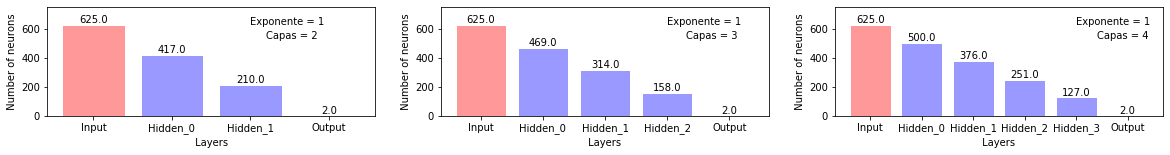

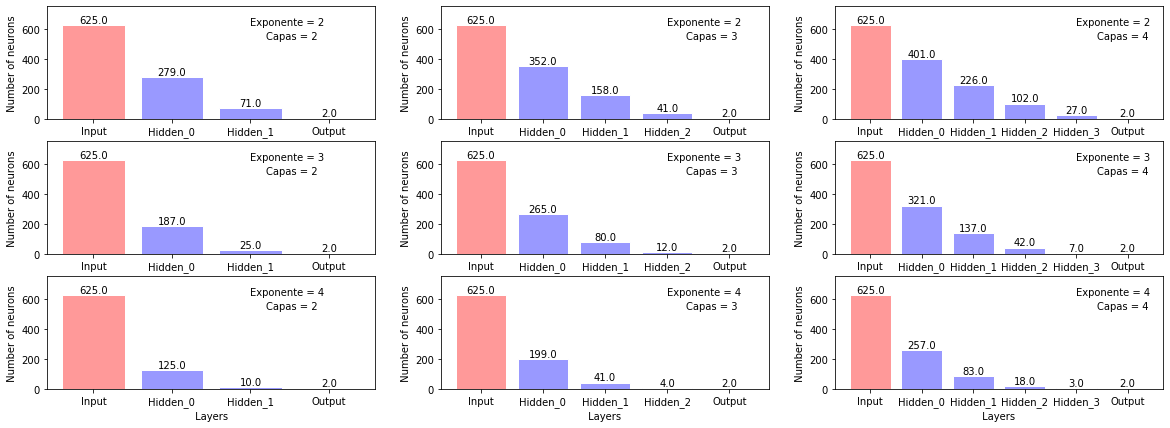

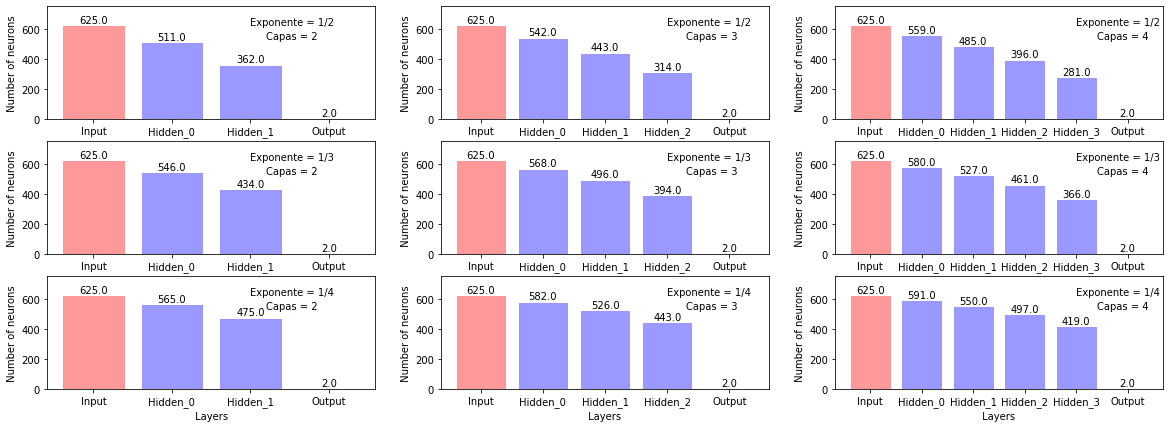

In [6]:
## GRAFICO DE VARIACION DEL PARAMETRO DE SELECCION NEURONAL POR CAPAS INCLUIDAS
def graf_capas_neuronas( exp , n_capas , config):
    config.exp = exp; config.n_capas  = n_capas;  
    config = neuronas( config )
    for i in range(len(config.matrix_neuronas)):
        if  i == 0:
            X = ["Input"]
        elif i== len(config.matrix_neuronas)-1:
            X.append("Output")
        else: 
            X.append(f"Hidden_{i-1}")
    Y = config.matrix_neuronas#(1 - X / float(n)) * np.random.uniform(0.5, 1.0, n)
    pl.bar(X[0], Y[0], facecolor='#ff9999', edgecolor='white')
    pl.bar(X[1:-1], Y[1:-1], facecolor='#9999ff', edgecolor='white')
    pl.bar(X[-1], Y[-1], facecolor='#ff9999', edgecolor='white')

    for x, y in zip(X, Y):
        pl.text(x , y + 0.05, '%.1f' % y, ha='center', va='bottom')
    pl.ylabel(' Number of neurons ') ;         pl.xlabel(' Layers ')
    pl.ylim(0, max(config.matrix_neuronas)*1.2)
    if exp >0:
        pl.text( n_capas , max(config.matrix_neuronas) , f"Exponente = {exp}")
    else:
        pl.text( n_capas , max(config.matrix_neuronas) , f"Exponente = 1/{-exp}")
    pl.text( n_capas*1.1 , max(config.matrix_neuronas)*85/100 , f"Capas ocultas = {n_capas}")   

#fig, axs = plt.subplots(3,3)
#fig.suptitle('Structure of layers and neurons')
#axs[0]
plt.rcParams['figure.figsize'] = [20, 2]
plt.figure(1)
plt.subplot(131); graf_capas_neuronas( 1 , 2 , config) 
plt.subplot(132); graf_capas_neuronas( 1 , 3 , config) 
plt.subplot(133); graf_capas_neuronas( 1 , 4 , config)

plt.rcParams['figure.figsize'] = [20, 12]
plt.figure(2)
plt.subplot(531); graf_capas_neuronas( 2 , 2 , config) 
plt.subplot(532); graf_capas_neuronas( 2 , 3 , config) 
plt.subplot(533); graf_capas_neuronas( 2 , 4 , config)
plt.subplot(534); graf_capas_neuronas( 3 , 2 , config) 
plt.subplot(535); graf_capas_neuronas( 3 , 3 , config) 
plt.subplot(536); graf_capas_neuronas( 3 , 4 , config)
plt.subplot(537); graf_capas_neuronas( 4 , 2 , config) 
plt.subplot(538); graf_capas_neuronas( 4 , 3 , config) 
plt.subplot(539); graf_capas_neuronas( 4 , 4 , config) 
plt.figure(3)
plt.subplot(531); graf_capas_neuronas( -2 , 2 , config) 
plt.subplot(532); graf_capas_neuronas( -2 , 3 , config) 
plt.subplot(533); graf_capas_neuronas( -2 , 4 , config) 
plt.subplot(534); graf_capas_neuronas( -3 , 2 , config) 
plt.subplot(535); graf_capas_neuronas( -3 , 3 , config) 
plt.subplot(536); graf_capas_neuronas( -3 , 4 , config) 
plt.subplot(537); graf_capas_neuronas( -4 , 2 , config) 
plt.subplot(538); graf_capas_neuronas( -4 , 3 , config) 
plt.subplot(539); graf_capas_neuronas( -4 , 4 , config) 

In [7]:
exp = [-4, -3, -2, -1 , 1, 2, 3, 4]
n_capas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X, Y = np.meshgrid(exp , n_capas, sparse=False, indexing='ij')
#print(X)
#print(Y)
#print(np.zeros(X.shape))

In [29]:
## CARACTERIZAR SI CAMBIA EL TIEMPO MEDIO DE UNA ITERACION CON LA VARIACION DE LAS CAPAS Y NEURONAS
##PARA UN learning_rate = CONST = .1
time_input = timeit.default_timer();
config.learning_rate = .01 ; config.acc_corte = .7; 
print(config)
exp = [-3, -2, -1 , 1, 2, 3] ;                           n_capas = [1, 2, 3, 4, 5, 6] ;
X, Y = np.meshgrid(exp , n_capas, sparse=False, indexing='ij') ; 
Z_1 = np.zeros(X.shape) ;  Z_2 = np.zeros(X.shape) ;  Z_3 = np.zeros(X.shape) ; 
for x in range( len(X) ): 
    #print(x)
    for y in range( len(Y) ):
        #print(y)
        time_ite_ALL         = np.ones(config.n_iterations_resul_mean) ;
        loss_ALL             = np.ones(config.n_iterations_resul_mean);
        n_iterations_acc_ALL = np.ones(config.n_iterations_resul_mean) ;
        config = estructura( INPUT_LINEAL, OUTPUT_LINEAL , config ); # ACTUALIZAR LA ESTRUCTURA PARA ENTRENAR
        for i in range(config.n_iterations_resul_mean):
            config.exp = X[ x , y ] ;               config.n_capas = Y[ x , y ]
            config = inicio( INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL , OUTPUT_LINEAL_TEST , config) # CORRER EL PROGRAMA
            
            # INCLUIR DENTRO DEL VECTOR DE RESULTADOS
            time_ite_ALL[i]         = config.time_ite_mean ;
            loss_ALL[i]             = config.loss ;
            n_iterations_acc_ALL[i] = config.n_iterations_acc ;
       
        # OBTENER LOS VALORES IMPORTANTES DE CADA ITERACION
        Z_1[ x , y ] = stats.mean( time_ite_ALL );         dZ_1[ x , y ] = stats.stdev( time_ite_ALL );   
        Z_2[ x , y ] = stats.mean( loss_ALL );             dZ_1[ x , y ] = stats.stdev( loss_ALL );  
        Z_3[ x , y ] = stats.mean( n_iterations_acc_ALL ); dZ_1[ x , y ] = stats.stdev( n_iterations_acc_ALL );  
    
    
    # MENSAJE DE SALIDA    
    clear_output(True)
    porciento = ( len(X) ) / ( x ); 
    print("\n Se ha realizado " , porciento , "\t % de la corrida, Lleva en ejecucionn ", time_input - timeit.default_timer())
    print("\n Accuracy on test set:", config.test_accuracy , "\t Mean time of Iterations:", str(config.time_ite_mean) )
    print("\n Exponente:", config.test_accuracy , "\t Mean time of Iterations:", str(config.time_ite_mean) )

    #print( np.append( np.round(Z_1,1) , np.round(Z_2,1) , axis=0) )
    #print(Z_2)
  

#config = inicio( INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL , OUTPUT_LINEAL_TEST , config )

Tensor("Placeholder:0", shape=(None,), dtype=float32)
Iteration 0 	| Loss = 0.77995235 	| Accuracy = 0.59950465 	| Time = 2.7798947
Iteration 1 	| Loss = 0.5583488 	| Accuracy = 0.7545013

 Accuracy on test set: 0.7569524 	 Mean time of Iterations: 2.4553866500000368
Iteration 0 	| Loss = 11.512709 	| Accuracy = 0.59950465 	| Time = 3.2608355999999503
Iteration 2 	| Loss = 0.5430227 	| Accuracy = 0.77288747

 Accuracy on test set: 0.7710476 	 Mean time of Iterations: 2.6424809000000096
Iteration 0 	| Loss = 34.140247 	| Accuracy = 0.59950465 	| Time = 3.5004480000000058
Iteration 8 	| Loss = 0.41140464 	| Accuracy = 0.86024576

 Accuracy on test set: 0.85714287 	 Mean time of Iterations: 2.866101477777761
Iteration 0 	| Loss = 101.93248 	| Accuracy = 0.59950465 	| Time = 3.667139900000052
Iteration 10 	| Loss = 2.518639 	| Accuracy = 0.43583882 	| Time = 3.3708846000000676
Iteration 11 	| Loss = 1.2553346 	| Accuracy = 0.7011527

 Accuracy on test set: 0.6952381 	 Mean time of Iteratio

Iteration 0 	| Loss = 9.44789 	| Accuracy = 0.59950465 	| Time = 10.204647600000044
Iteration 10 	| Loss = 0.50887835 	| Accuracy = 0.7994665 	| Time = 8.69909000000007
Iteration 10 	| Loss = 0.50887835 	| Accuracy = 0.7994665

 Accuracy on test set: 0.8 	 Mean time of Iterations: 9.303573109090973
Iteration 0 	| Loss = 23.746717 	| Accuracy = 0.40049538 	| Time = 10.81564810000009
Iteration 10 	| Loss = 0.7952691 	| Accuracy = 0.40544918 	| Time = 9.578948200000013
Iteration 12 	| Loss = 0.5069378 	| Accuracy = 0.73440033

 Accuracy on test set: 0.72952384 	 Mean time of Iterations: 9.27274103846153
Iteration 0 	| Loss = 39.051605 	| Accuracy = 0.40049538 	| Time = 10.565895200000341
Iteration 7 	| Loss = 0.47249302 	| Accuracy = 0.74583215

 Accuracy on test set: 0.73904765 	 Mean time of Iterations: 9.398140775000059
Iteration 0 	| Loss = 57.005013 	| Accuracy = 0.40049538 	| Time = 10.975283399999626
Iteration 8 	| Loss = 10.159471 	| Accuracy = 0.7532628

 Accuracy on test set: 0.

In [72]:
print(X.shape)

(8, 10)


In [34]:
np.savetxt('Z_1.txt',Z_1)
np.savetxt('Z_2.txt',Z_2)
np.savetxt('Z_3.txt',Z_3)
np.savetxt('X.txt',X)
np.savetxt('Y.txt',Y)


In [38]:
# Tomo el eje actual y defino una proyección 3D
ax = gca(projection='3d')
surface = ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)


NameError: name 'gca' is not defined

AttributeError: 'AxesSubplot' object has no attribute 'plot_surface'

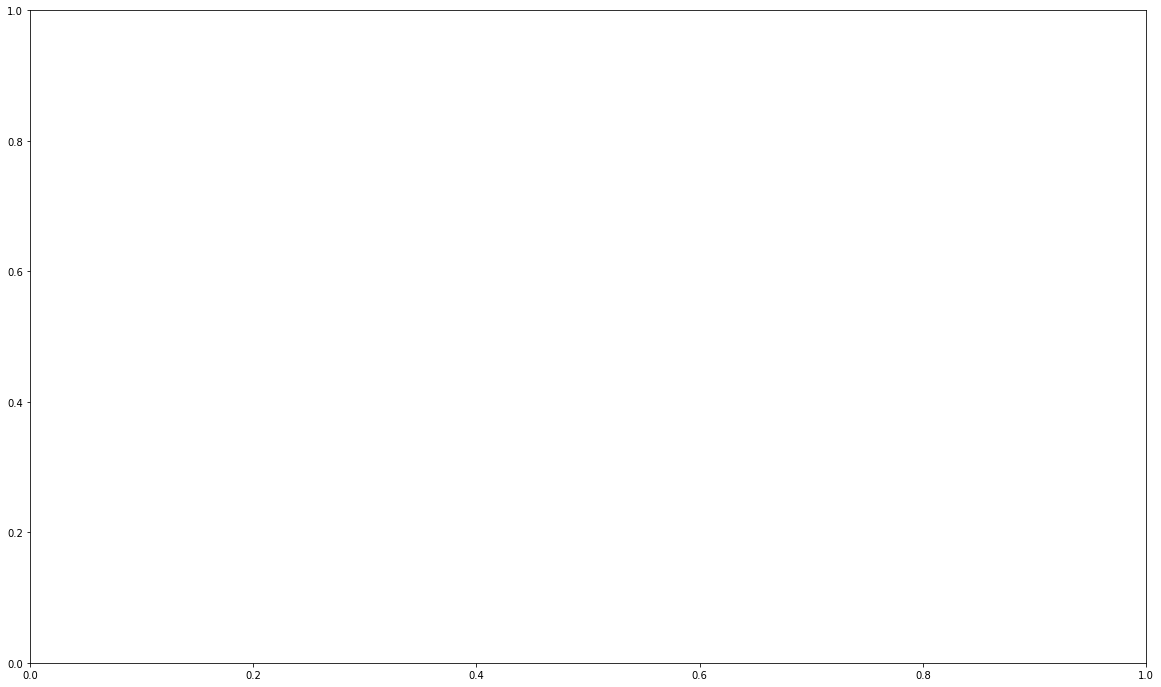

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm

# Figura
fig = plt.figure()

# Tomo el eje actual y defino una proyección 3D
ax = plt.gca()#projection = '3d')
# Grafico surface en 3D
#ax.plot_surface(X, Y, X, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_surface(X, Y, Z_1 ,rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
# Límites del eje Z
#ax.set_zlim(-1.01, 1.01)

# Barra de nivel, un poco más pequeña
#fig.colorbar(plt.surf, shrink=0.5, aspect=10)

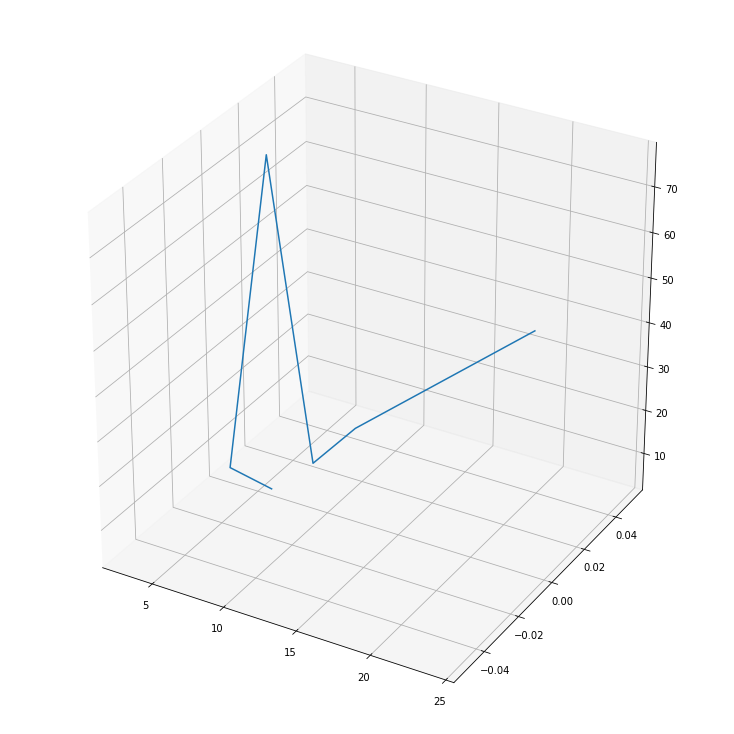

In [61]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = Axes3D(fig)

x = [6,3,6,9,12,24]
y = [3,5,78,12,23,56]
# put 0s on the y-axis, and put the y axis on the z-axis
surf = ax.plot(xs=x, ys=[0]*len(x), zs=y, zdir='z', label='ys=0, zdir=z')
plt.show(surf)

In [ ]:
def potencia(c):
    """Calcula y devuelve el conjunto potencia del 
       conjunto c.
    """
    if len(c) == 0:
        return [[]]
    r = potencia(c[:-1])
    return r + [s + [c[-1]] for s in r]

def imprime_ordenado(c):
    """Imprime en la salida estándar todos los
       subconjuntos del conjunto c (una lista de
       listas) ordenados primero por tamaño y
       luego lexicográficamente. Cada subconjunto
       se imprime en su propia línea. Los
       elementos de los subconjuntos deben ser
       comparables entre sí, de otra forma puede
       ocurrir un TypeError.
    """
    for e in sorted(c, key=lambda s: (len(s), s)):
        print(e)
        
def combinaciones(c, n):
    """Calcula y devuelve una lista con todas las
       combinaciones posibles que se pueden hacer
       con los elementos contenidos en c tomando n
       elementos a la vez.
    """
    return [s for s in potencia(c) if len(s) == n]

imprime_ordenado(combinaciones(['cereza', 'chocolate', 'fresa','nuez', 'vainilla'], 3))

In [ ]:
'''# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
 
# Get the data (csv file is hosted on the web)
url = 'https://python-graph-gallery.com/wp-content/uploads/volcano.csv'
data = pd.read_csv(url)
 
# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# We are going to do 20 plots, for 20 different angles
for angle in range(70,210,2):
 
    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
 
    # Set the angle of the camera
    ax.view_init(30,angle)
 
    # Save it
    filename='Volcano_step'+str(angle)+'.png'
    plt.savefig(filename, dpi = 96)
    plt.gca()
#Then use image magic to transform all the png files into an GIF file.

# Then use image magick (this is bash, not python)
#convert -delay 50 Volcano*.png animated_volcano.gif'''

In [ ]:
#convert -delay 50 Volcano*.png animated_volcano.gif

TypeError: Object of type ndarray is not JSON serializable

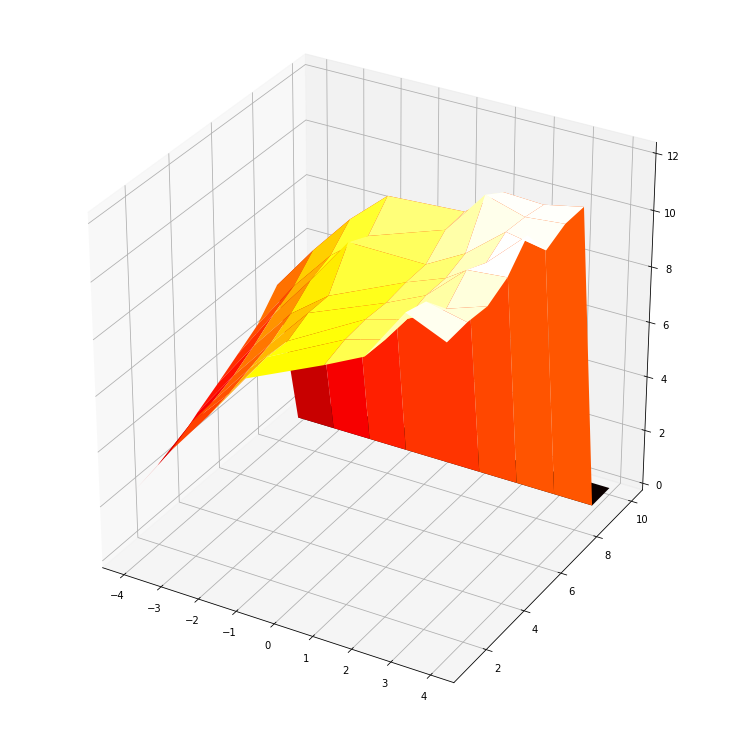

TypeError: Object of type ndarray is not JSON serializable

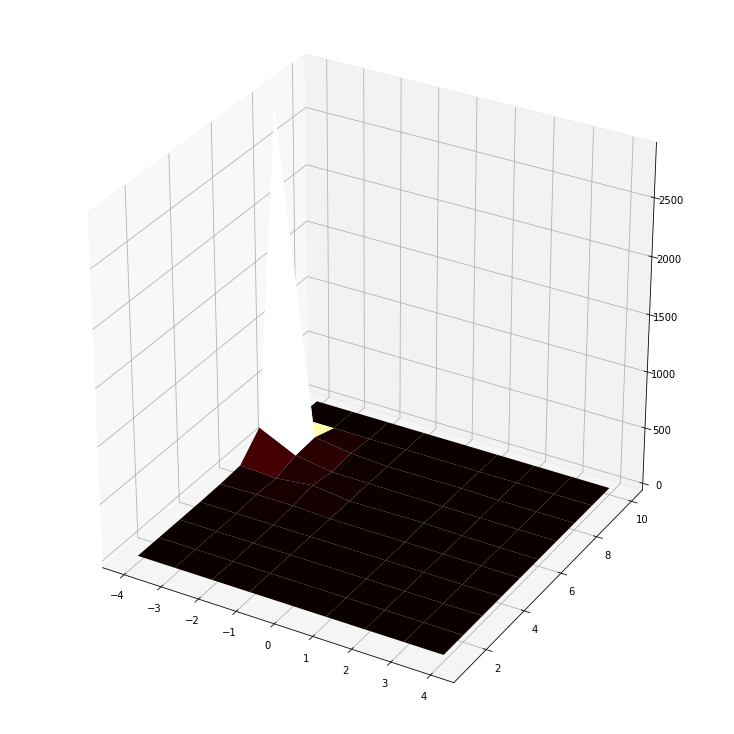

TypeError: Object of type ndarray is not JSON serializable

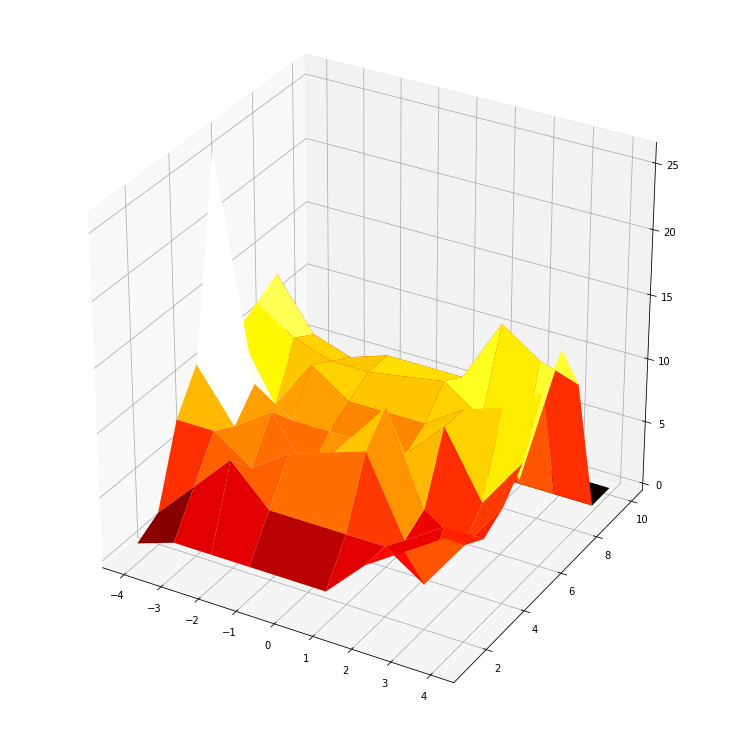

In [77]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure()
ax = Axes3D(fig)
'''X = np.arange(-4, 4, 0.25)
Y = np.arange(-4, 4, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)'''
X, Y = np.meshgrid(exp , n_capas, sparse=False, indexing='ij') ; 

ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, cmap='hot')
fig = pl.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, cmap='hot')
fig = pl.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z_3, rstride=1, cstride=1, cmap='hot')

In [86]:
print( Z_2)
''' # OBTENER LOS VALORES IMPORTANTES DE CADA ITERACION
        Z_1[ x , y ] = stats.mean( time_ite_ALL );         dZ_1[ x , y ] = stats.stdev( time_ite_ALL );   
        Z_2[ x , y ] = stats.mean( loss_ALL );             dZ_1[ x , y ] = stats.stdev( loss_ALL );  
        Z_3[ x , y ] = stats.mean( n_iterations_acc_ALL ); dZ_1[ x , y ] = stats.stdev( n_iterations_acc_ALL ); '''

[[5.58348775e-01 5.43022692e-01 4.11404639e-01 1.25533462e+00
  5.56033850e+00 1.82667751e+01 2.12228821e+02 2.89984229e+03
  0.00000000e+00 0.00000000e+00]
 [5.33047438e-01 4.65043366e-01 6.98936105e-01 8.96556675e-01
  1.33777895e+01 3.16730523e+00 5.62627716e+01 6.95302200e+01
  0.00000000e+00 0.00000000e+00]
 [5.61113238e-01 4.36381876e-01 3.62048179e-01 2.67464489e-01
  1.50108070e+01 4.18651505e+01 5.27069855e+00 2.25387764e+01
  0.00000000e+00 0.00000000e+00]
 [5.55175245e-01 5.48271179e-01 4.82674360e-01 6.16559744e-01
  3.29679370e-01 8.05359364e-01 3.52412748e+00 9.12126124e-01
  0.00000000e+00 0.00000000e+00]
 [5.60017288e-01 5.71733654e-01 5.08878350e-01 5.06937802e-01
  4.72493023e-01 1.01594706e+01 7.08804846e-01 6.28405714e+00
  0.00000000e+00 0.00000000e+00]
 [5.50074220e-01 6.02769434e-01 6.57508075e-01 5.95013082e-01
  4.67535585e-01 5.13853014e-01 4.77041095e-01 2.52372861e-01
  0.00000000e+00 0.00000000e+00]
 [5.67449212e-01 6.18910253e-01 5.24995625e-01 6.72961533e

' # OBTENER LOS VALORES IMPORTANTES DE CADA ITERACION\n        Z_1[ x , y ] = stats.mean( time_ite_ALL );         dZ_1[ x , y ] = stats.stdev( time_ite_ALL );   \n        Z_2[ x , y ] = stats.mean( loss_ALL );             dZ_1[ x , y ] = stats.stdev( loss_ALL );  \n        Z_3[ x , y ] = stats.mean( n_iterations_acc_ALL ); dZ_1[ x , y ] = stats.stdev( n_iterations_acc_ALL ); '

TypeError: Object of type ndarray is not JSON serializable

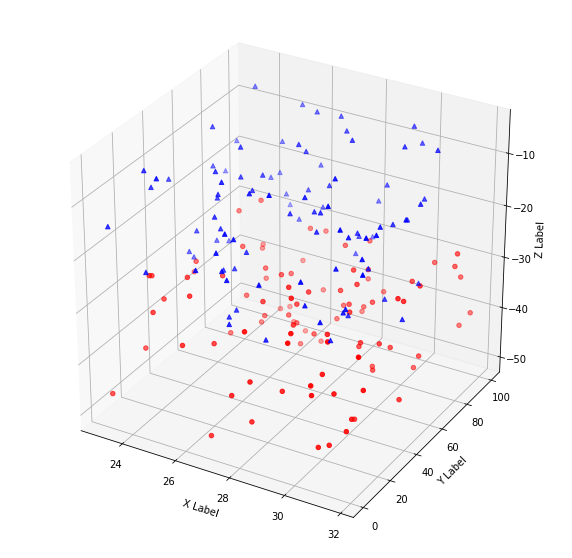

In [97]:
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
def randrange(n, vmin, vmax): return (vmax-vmin)*np.random.rand(n) + vmin

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
n = 100 
for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]: 
    xs = randrange(n, 23, 32) 
    ys = randrange(n, 0, 100) 
    zs = randrange(n, zl, zh) 
    
    ax.scatter(xs, ys, zs, c=c, marker=m)
    ax.set_xlabel('X Label') 
    ax.set_ylabel('Y Label') 
    ax.set_zlabel('Z Label')

    x = np.linspace(0, 2*np.pi, 50) 
    y = np.sin(x) 
    y2 = y + 0.1 * np.random.normal(size=x.shape)

#display(fig)